In [30]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import pytorch_lightning as pl
import torch.nn as nn
from torchvision.models import resnet34
import torch.nn.functional as F

%matplotlib inline

In [34]:
class ResNet_SimCLR(nn.Module):
    def __init__(self, n_embedding):
        super(ResNet_SimCLR, self).__init__()
        self.backbone = resnet34()
        self.backbone.fc = nn.Identity()
        
        self.backbone.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        
        self.projection = nn.Sequential(nn.Linear(512, 2048),
                        nn.ReLU(),
                        nn.Dropout(p=0.5),
                        nn.Linear(2048, 1024),
                        nn.ReLU(),
                        nn.Dropout(p=0.3),
                        nn.Linear(1024, n_embedding))
        
    
    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        
        if return_embedding:
            return embedding
        
        return self.projection(embedding)
                                       

In [35]:
model = ResNet_SimCLR(10)

In [36]:
model

ResNet_SimCLR(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [11]:
file_path = r"C:\Users\shmak\Documents\Jupyter Files\Image_segmentation\HuBMAP dataset\train\no_masks"

5400

In [124]:
base_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomResizedCrop(size=512),
                                transforms.RandomApply([
                                    transforms.ColorJitter(brightness=0.5,
                                                          contrast=0.2,
                                                          saturation=0.5,
                                                          hue=0.1)
                                ], p=0.8),
                                transforms.RandomGrayscale(p=0.2),
                                transforms.GaussianBlur(kernel_size=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

In [125]:
class File_loader(Dataset):
    
    def __init__(self, file_path, base_transforms, n = 2):
        self.file_path = file_path
        self.file_list = os.listdir(file_path)
        self.n = n
        self.base_transforms = base_transforms
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, i):
        if torch.is_tensor(i):
            index = index.tolist()
        
        img_name = os.path.join(self.file_path,
                               self.file_list[i])
        
        img = Image.open(img_name)
        
        return [self.base_transforms(img) for i in range(self.n)]

In [144]:
dataset = File_loader(file_path=file_path, base_transforms=base_transforms)

train_data = DataLoader(dataset, shuffle=True)

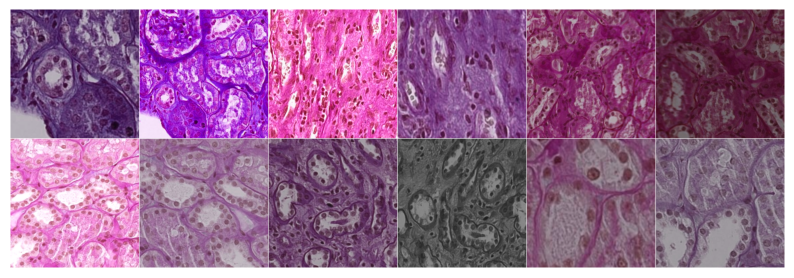

In [149]:
n_imgs = 6

imgs = torch.stack([img for i in range(n_imgs) for img in dataset[i]], dim=0)

img_grid = torchvision.utils.make_grid(imgs, nrow=n_imgs, normalize=True, pad_value=1)
img_grid = img_grid.permute(1,2,0)

plt.figure(figsize=(10,5))
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super.__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        self.convnet.fc = 